<h1>Data Science Capstone Project - Minsk restaurants</h1>

<h2>Introduction</h2>

Minsk is a business and cultural center of Belarus. Food industry in Minsk develops really fast. Cafes and restaurants of all kinds appear one after another. What is wonderful, most of fast food places people are used to see in other spots of the world still are nowhere to find in Minsk: no Subway or Starbucks, but there are still tens of places you can choose from.

<h2> The Problem</h2>

Over the last 5 years the number of restaurants has trippled, the growing market makes investors become more interested in the location. The aim of this project is to specify most prospective locations in Misnk to open a restaurant.

<h2>Interest</h2>
Obviously, investors shall be very interested in accurate prediction of profitable restaurant locations to obtain competitive advantage and business values.

<h2> Data </h2>

The soluition will be based on analysis of most popular restaurants according to Foursquare information. The restaurants will be clustered to search for a midpoint with a certain radius, where and which type of restaurants are of high demand.

<h2>Methodology</h2>

Import all necessary libraries

In [1]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors


Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.49         |             py_0          32 KB  conda-forge
    certifi-2019.6.16          |           py36_0         148 KB  conda-forge
    ca-certificates-2019.6.16  |       hecc5488_0         145 KB  conda-forge
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    openssl-1.1.1c             |       h516909a_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.49-py_0         conda-forge
    geopy:           1.20.0-py_0       conda-forge

The following packages will be UPDATED:

    ca-

Define Foursquare credentials

In [2]:
CLIENT_ID = 'WP0G0SA33UAV1BV40GXMPXNJLRPEA4SZFXKH4F4QZ5YBTMIK' 
CLIENT_SECRET = 'GXAW0MOLVMFXLDD04EUEIECJIUM5IEQF0G44ATLTRGRIQZZS'
VERSION = '20180604'
LIMIT = 500

Set geolcocation to Minsk, Belarus

In [3]:
address = 'Minsk, Belarus'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)


53.902334 27.5618791


Let's define the API url. The diameter of Minsk is aproximately 20 km, therefore set radius of search equal to 10000. As we are researching restaurants market, set search query to "restaurant".

In [4]:
radius=10000
search_query = 'restaurant'
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
results = requests.get(url).json()
# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = json_normalize(venues)

Keep only columns that include venue name, and anything that is associated with location

In [5]:
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

dataframe_filtered


,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,postalCode,state,id
0,Empire restaurant (in Crowne Plaza hotel),Breakfast Spot,NaN,BY,NaN,Беларусь,NaN,925,[Беларусь],"[{'label': 'display', 'lat': 53.895192, 'lng':...",53.895192,27.554662,NaN,NaN,5243ce2911d2e4f9bbb2499b
1,Franky Restaurant&Cocktail Bar,Restaurant,Ленина 13,BY,Мінск,Беларусь,NaN,372,"[Ленина 13, Мінск, Беларусь]","[{'label': 'display', 'lat': 53.89902, 'lng': ...",53.899020,27.561071,NaN,Мінск,5c4348da5f68b9002c326260
2,Hotel Europe Restaurant,French Restaurant,NaN,BY,NaN,Беларусь,NaN,330,[Беларусь],"[{'label': 'display', 'lat': 53.90259662295573...",53.902597,27.556856,NaN,NaN,4bc0d44a4cdfc9b6dd919321
3,Restaurant President Hotel,Restaurant,NaN,BY,NaN,Беларусь,NaN,463,[Беларусь],"[{'label': 'display', 'lat': 53.89893159858217...",53.898932,27.565959,NaN,NaN,561b4704498e81a71a796ad2
4,Istanbul Cafe & Restaurant,Turkish Restaurant,Ресторан Istanbul Cafe Minsk,BY,Minsk,Беларусь,NaN,353,"[Ресторан Istanbul Cafe Minsk, Minsk, Беларусь]","[{'label': 'display', 'lat': 53.9055, 'lng': 2...",53.905500,27.561444,NaN,Minsk Bölgesi,5c72536ff2554e0039daf5bc
5,Restaurant in Hampton by Hilton,Hotel,Ул. Толстого 8,BY,Мінск,Беларусь,NaN,1916,"[Ул. Толстого 8, Мінск, Беларусь]","[{'label': 'display', 'lat': 53.88892224976847...",53.888922,27.543567,NaN,Мінск,56ee61da498edb1ceea0b535
6,Restaurant ciros Pamidoro,Italian Restaurant,NaN,BY,NaN,Беларусь,NaN,1453,[Беларусь],"[{'label': 'display', 'lat': 53.90467195648948...",53.904672,27.540070,NaN,NaN,545d1a7b498ee0638901aa8c
7,Astoria Restaurant,Restaurant,"Myasnikova, 25",BY,Мінск,Беларусь,NaN,1161,"[Myasnikova, 25, Мінск, Беларусь]","[{'label': 'display', 'lat': 53.8988, 'lng': 2...",53.898800,27.545221,NaN,Мінск,5cd5c2f1c0af57002cf2ca90
8,Turkish Restaurant,Turkish Restaurant,NaN,BY,NaN,Беларусь,NaN,732,[Беларусь],"[{'label': 'display', 'lat': 53.90385, 'lng': ...",53.903850,27.551007,NaN,NaN,52d7a859498e11715dfb3210
9,Fancy Restaurant,Cafeteria,NaN,BY,NaN,Беларусь,NaN,769,[Беларусь],"[{'label': 'display', 'lat': 53.89594, 'lng': ...",53.895940,27.557423,NaN,NaN,4c7e96d2171b224bf84f0eb1


Generate Minsk map

In [7]:
venues_map = folium.Map(location=[latitude, longitude], zoom_start=13)

# add a red circle marker to represent the Minsk center
folium.features.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='Minsk center',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)

# add restaurants as blue circle markers
for lat, lng, label in zip(dataframe_filtered.lat, dataframe_filtered.lng, dataframe_filtered.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)

# display map
venues_map

Define KMeans clusters

In [58]:
kclusters = 6

minsk_grouped_clustering = dataframe_filtered[['lat','lng']]
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(minsk_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

# add clustering labels
minsk_grouped_clustering.insert(0, 'Cluster Labels', kmeans.labels_)

minsk_merged = dataframe_filtered

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
minsk_merged = minsk_merged.merge(minsk_grouped_clustering.set_index('lat'), on='lat')

minsk_merged.head() 

,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng_x,postalCode,state,id,Cluster Labels,lng_y
0,Empire restaurant (in Crowne Plaza hotel),Breakfast Spot,NaN,BY,NaN,Беларусь,NaN,925,[Беларусь],"[{'label': 'display', 'lat': 53.895192, 'lng':...",53.895192,27.554662,NaN,NaN,5243ce2911d2e4f9bbb2499b,3,27.554662
1,Franky Restaurant&Cocktail Bar,Restaurant,Ленина 13,BY,Мінск,Беларусь,NaN,372,"[Ленина 13, Мінск, Беларусь]","[{'label': 'display', 'lat': 53.89902, 'lng': ...",53.899020,27.561071,NaN,Мінск,5c4348da5f68b9002c326260,3,27.561071
2,Hotel Europe Restaurant,French Restaurant,NaN,BY,NaN,Беларусь,NaN,330,[Беларусь],"[{'label': 'display', 'lat': 53.90259662295573...",53.902597,27.556856,NaN,NaN,4bc0d44a4cdfc9b6dd919321,3,27.556856
3,Restaurant President Hotel,Restaurant,NaN,BY,NaN,Беларусь,NaN,463,[Беларусь],"[{'label': 'display', 'lat': 53.89893159858217...",53.898932,27.565959,NaN,NaN,561b4704498e81a71a796ad2,3,27.565959
4,Istanbul Cafe & Restaurant,Turkish Restaurant,Ресторан Istanbul Cafe Minsk,BY,Minsk,Беларусь,NaN,353,"[Ресторан Istanbul Cafe Minsk, Minsk, Беларусь]","[{'label': 'display', 'lat': 53.9055, 'lng': 2...",53.905500,27.561444,NaN,Minsk Bölgesi,5c72536ff2554e0039daf5bc,3,27.561444


In [13]:

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(minsk_merged['lat'], minsk_merged['lng_x'], minsk_merged['name'], minsk_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [62]:
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style


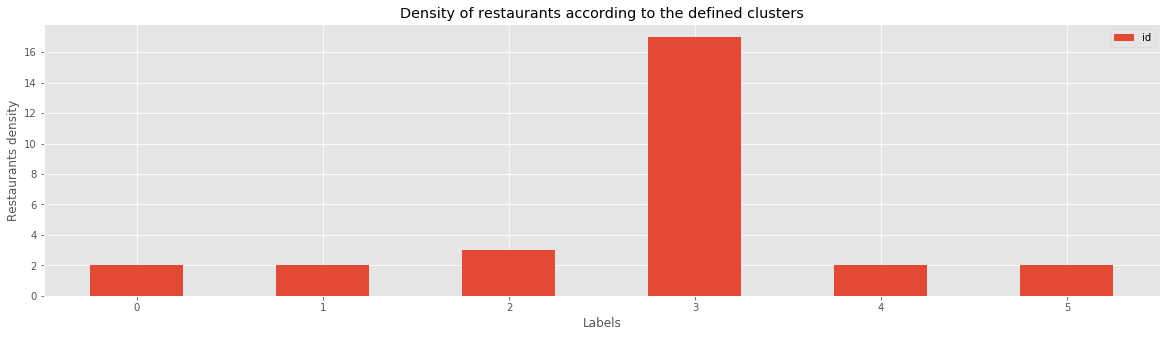

In [68]:
cluster_df = minsk_merged.groupby(by="Cluster Labels").count()
cluster_df.drop(columns=['name', 'categories','address','cc','city','country'], inplace=True)
cluster_df.drop(columns=['crossStreet', 'distance','formattedAddress','labeledLatLngs','lat','lng_x','lng_y','postalCode','state'],inplace=True)
cluster_df.plot(kind='bar', figsize=(20, 5))
plt.xlabel('Labels') # add to x-label to the plot
plt.xticks(rotation=0)
plt.ylabel('Restaurants density') # add y-label to the plot
plt.title('Density of restaurants according to the defined clusters') # add title to the plot

plt.show()

As shown on barchart the highest density of restaurants appears in cluster 3. Now define maximum radius to search for a new restaurant location.

In [80]:
cl3=minsk_merged.loc[lambda minsk_merged: minsk_merged['Cluster Labels']==3]
print("The new restaurant sholud be located not more than", cl3['distance'].max(), "meters away from Minsk center")

The new restaurant sholud be located not more than 1916 meters away from Minsk center
